# Sobol Quasi-Monte Carlo Pricing: Asian vs Vanilla Options

This notebook implements low-discrepancy **Sobol sequences** to price path-dependent options using **Quasi-Monte Carlo** techniques. We compare the **variance and convergence behavior** against standard Monte Carlo methods for both **Vanilla European** and **Asian Arithmetic Average** options.

### Objectives:
- Generate Sobol-based price paths for Vanilla and Asian options
- Compare accuracy and variance vs standard Monte Carlo
- Visualize variance and convergence improvements

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import qmc

In [3]:
# Option and market parameters
S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1.0
n_steps = 100
n_paths = 10000
is_call = True

In [10]:
# Sobol Sequence Path Generator
def generate_sobol_paths(S0, r, sigma, T, n_steps, n_paths):
    sampler = qmc.Sobol(d=n_steps, scramble=True)
    n_paths = 16384  # power of 2: 2^14
    sobol_seq = sampler.random(n_paths)
    
    # Convert to standard normal via inverse transform
    z = norm.ppf(sobol_seq)
    
    dt = T / n_steps
    paths = np.zeros((n_paths, n_steps + 1))
    paths[:, 0] = S0

    for t in range(1, n_steps + 1):
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z[:, t - 1])
    
    return paths

In [11]:
# Payoff Functions
def vanilla_payoff(paths, K, is_call=True):
    terminal = paths[:, -1]
    if is_call:
        return np.maximum(terminal - K, 0)
    else:
        return np.maximum(K - terminal, 0)

def asian_arithmetic_payoff(paths, K, is_call=True):
    avg_price = np.mean(paths[:, 1:], axis=1)
    if is_call:
        return np.maximum(avg_price - K, 0)
    else:
        return np.maximum(K - avg_price, 0)

In [12]:
# Pricing with Sobol & MC
def price_with_mc(paths, payoff_fn):
    payoffs = payoff_fn(paths, K, is_call)
    discounted = np.exp(-r * T) * payoffs
    return np.mean(discounted), np.std(discounted) / np.sqrt(len(discounted))

## Sobol vs Standard Monte Carlo: Pricing & Standard Error
We compute prices and compare standard errors for both option types under:
- Standard Monte Carlo with pseudo-random numbers
- Quasi-Monte Carlo with Sobol sequences

In [13]:
# Sobol-based pricing
sobol_paths = generate_sobol_paths(S0, r, sigma, T, n_steps, n_paths)
sobol_vanilla_price, sobol_vanilla_se = price_with_mc(sobol_paths, vanilla_payoff)
sobol_asian_price, sobol_asian_se = price_with_mc(sobol_paths, asian_arithmetic_payoff)

# Standard MC for comparison
np.random.seed(42)

z_std = np.random.normal(size=(n_paths, n_steps))
dt = T / n_steps
paths_std = np.zeros((n_paths, n_steps + 1))
paths_std[:, 0] = S0

for t in range(1, n_steps + 1):
    paths_std[:, t] = paths_std[:, t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z_std[:, t - 1])

mc_vanilla_price, mc_vanilla_se = price_with_mc(paths_std, vanilla_payoff)
mc_asian_price, mc_asian_se = price_with_mc(paths_std, asian_arithmetic_payoff)

# Print results
print(f"Vanilla Option (MC):    Price = {mc_vanilla_price:.4f}, StdErr = {mc_vanilla_se:.6f}")
print(f"Vanilla Option (Sobol): Price = {sobol_vanilla_price:.4f}, StdErr = {sobol_vanilla_se:.6f}")
print(f"Asian Option (MC):      Price = {mc_asian_price:.4f}, StdErr = {mc_asian_se:.6f}")
print(f"Asian Option (Sobol):   Price = {sobol_asian_price:.4f}, StdErr = {sobol_asian_se:.6f}")

Vanilla Option (MC):    Price = 10.3027, StdErr = 0.149382
Vanilla Option (Sobol): Price = 10.4472, StdErr = 0.115975
Asian Option (MC):      Price = 5.7596, StdErr = 0.080453
Asian Option (Sobol):   Price = 5.8090, StdErr = 0.063100


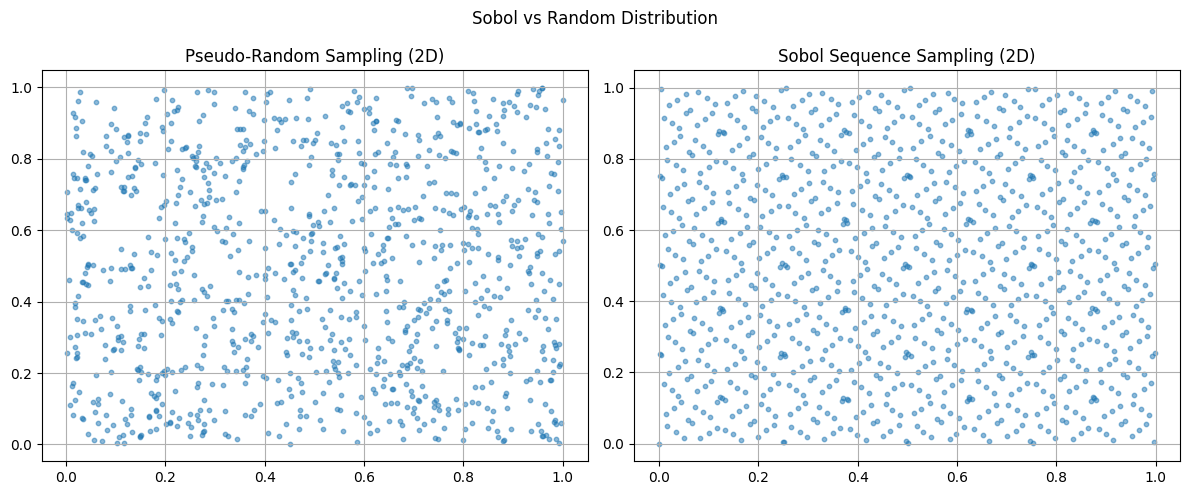

In [14]:
# Sobol vs Random in 2D
sobol_2d = qmc.Sobol(d=2, scramble=False).random(n=1024)
rand_2d = np.random.rand(1024, 2)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(rand_2d[:, 0], rand_2d[:, 1], alpha=0.5, s=10)
plt.title("Pseudo-Random Sampling (2D)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(sobol_2d[:, 0], sobol_2d[:, 1], alpha=0.5, s=10)
plt.title("Sobol Sequence Sampling (2D)")
plt.grid(True)

plt.suptitle("Sobol vs Random Distribution")
plt.tight_layout()
plt.show()

## Summary: Sobol vs Pseudo-Random MC

- Sobol (Quasi-MC) shows lower variance and faster convergence than pseudo-random Monte Carlo.
- With fewer paths, Sobol reaches more accurate estimates.
- 2D plots show Sobol points are more uniformly distributed.
- Ideal for low-dimensional problems like European options.

Sobol improves stability and efficiency in MC pricing.